## <div align = 'center'><b> CZ1115 Project - FS4 Group 4 </b></div>



### **Presented by**
1.   Samuel Leong
2.   Xavier Lee

Dataset: [TMDB Open Source Dataset]
(https://www.themoviedb.org/)


## **Problem Statments**

**Real life Problem**


> 1.    How can we effectively predict the likelihood of a movie sequel?

**Data Science Problem**


> 1.   What is the probability of a sequel given the characteristics of a movie? (Class Problem)
2.   Which movie property influences the prediction of a sequel the most?


**Assumption**

> 1.    Data in the dataset are correct. NULL and invalid data will be cleaned and intepreted accordingly.


**API KEY: ...**



### Essential Libraries to install

> 1. tmdbsimple
2. tqdm

## **Import Essential Libraries and Datasets**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extra libraries 
import tmdbsimple as tmdb
import requests

In [ ]:
# API Key
tmdb.REQUESTS_SESSION = requests.Session()
tmdb.API_KEY = '...'

In [ ]:
# Daily File Export 16 March 2021
movie_url = "http://files.tmdb.org/p/exports/movie_ids_03_16_2021.json.gz"

dailymovie = pd.read_json(movie_url, compression='gzip', lines = True)
# Taking ID Columns for further data extraction
daily_id = pd.DataFrame(dailymovie['id'])

In [ ]:
# Changing to list
id_listlist = daily_id.values.tolist()
id_list = []
for sublist in id_listlist:
    for item in sublist:
        id_list.append(item)

# Sort list to obtain linear time complexity search
id_list.sort()

In [ ]:
len(id_list)

589364

## <div align = 'center'><b> Data Extraction </b></div>

Using movie ID to get the respective movie details

In [ ]:
# Function to get data through movie ID listed in the daily export
def get_data(id):
  try:
    details = tmdb.Movies(id).info()
    return None, details
  except:
    return id, None

In [ ]:
#Extracting 500k dataset requires at least a day if done sequentially
#Multiprocessing speeds up the process to about 4-5hours
import time
from tqdm.contrib.concurrent import process_map
#start_time = time.time()
#from details import get_data

missing = []
missing, movieTemp = zip(*process_map(get_data, id_list, total=len(id_list),chunksize= 1))

print()
#print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
# Checking if the numbers of rows are extracted correctly
len(movieTemp)

NameError: name 'movieTemp' is not defined

In [ ]:
# Dropping all None data and changing float data types to int data types
missingDF = pd.DataFrame(missing)
missingDF_list = missingDF.dropna(how='all')
missing_list = missingDF_list.astype(int)

NameError: name 'missing' is not defined

In [ ]:
# Exporting the list of missing movies for data cleaning
missing_list.info()
missing_list.head()
missing_list.to_csv('missing_idlist.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [ ]:
# Extracting data to csv to prevent the need to rerun the extraction process every time which is 
# time consuming
movieTemp.to_csv('movie_data_uncleaned.csv')

## <div align = 'center'><b> Data Preparation and Cleaning </b></div>

In [ ]:
movie_list = pd.read_csv('/datasets/datasets/movie_dataset.csv', lineterminator='\n')
#missing_list = pd.read_csv('/datasets/datasets/missing_idlist.csv')
#missing_list.info()
movie_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589313 entries, 0 to 589312
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             589313 non-null  int64  
 1   adult                  589313 non-null  bool   
 2   backdrop_path          143714 non-null  object 
 3   belongs_to_collection  15253 non-null   object 
 4   budget                 589313 non-null  int64  
 5   genres                 589313 non-null  object 
 6   homepage               67222 non-null   object 
 7   id                     589313 non-null  int64  
 8   imdb_id                404201 non-null  object 
 9   original_language      589313 non-null  object 
 10  original_title         589312 non-null  object 
 11  overview               491241 non-null  object 
 12  popularity             589313 non-null  float64
 13  poster_path            380083 non-null  object 
 14  production_companies   589313 non-nu

<b>Dropping unnecessary columns that do not benefit the data prediction


In [ ]:
# Exclude irrelevant columns such as page links and indexings which does not provide us with more insights to our data
movie_list = movie_list.drop(['Unnamed: 0', 'backdrop_path', 'homepage', 'id', 'imdb_id', 'original_title', 
                              'overview', 'poster_path', 'production_companies', 'production_countries',
                              'release_date', 'spoken_languages', 'adult', 'status', 'tagline', 'title', 'video'], axis = 1)

# Save columns: belongs_to_collection, budget, genres, original_language, popularity, revenue, runtime, 
# vote_average, vote_count

<b>Cleaning Numeric Data

In [ ]:
# Relevant data that contains too many invalid data which would drastically affect our data collection sample
clean_data = movie_list.copy()



# As budget cannot be equal to 0, indicating there is absolutely 0 cost in producing the movie, 
# we will assume these data to be invalid.
clean_data = clean_data[clean_data['budget'] != 0]

# With reference to the below link, the highest budget used for a movie is $400,000,000. As such, we will consider any
# movie whose budget is more than $400,000,000 to be an invalid data. Thus, removing it from our dataset.
# https://www.the-numbers.com/movie/budgets/all
clean_data = clean_data[clean_data['budget'] <= 400000000]



# As a movie with $0 as revenue indicates that the movie is largely unsuccessful, it is unlikely that the producers would
# want to produce a sequel as it would not make any fiscal sense. As such, we will be removing these data to improve our
# data visualization later on
clean_data = clean_data[clean_data['revenue'] > 0]

# With reference to the below link, the highest revenue earned from a movie is approximately $2,800,000,000. As such, we will
# also consider any movie whose budget is more than $2,800,000,000 to be an invalid data. Thus, removing it from our data.
# https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time
clean_data = clean_data[clean_data['revenue'] <= 2800000000]



# As runtime cannot be equal to 0, indicating the movie runs for 0 minutes or NaN, we will assume those data to be invalid as well.
clean_data = clean_data[clean_data['runtime'] != 0]
clean_data = clean_data[~clean_data['runtime'].isnull()]


# As every movie has to contain at least one genre, we will assume movies with 0 genres to be invalid as well. Thus,
# removing it from our data.
clean_data = clean_data.loc[clean_data['genres'].str.len() != 2]

print('Cleaned Numeric Data:', len(clean_data))

Cleaned Numeric Data: 8401


In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8401 entries, 2 to 589307
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  1683 non-null   object 
 1   budget                 8401 non-null   int64  
 2   genres                 8401 non-null   object 
 3   original_language      8401 non-null   object 
 4   popularity             8401 non-null   float64
 5   revenue                8401 non-null   int64  
 6   runtime                8401 non-null   float64
 7   vote_average           8401 non-null   float64
 8   vote_count             8401 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 656.3+ KB


<b>Cleaning Categorical Data

Belongs to collection <br>


In [ ]:
# Replacing categories that belongs to a collection with 'Y' and others with 'N'.
clean_data.loc[~clean_data.belongs_to_collection.isnull(),'belongs_to_collection'] = 'Y'  # not NaN
clean_data.loc[clean_data.belongs_to_collection.isnull(), 'belongs_to_collection'] = 'N'
clean_data.belongs_to_collection.value_counts()

N    6718
Y    1683
Name: belongs_to_collection, dtype: int64

Genres

In [ ]:
import re
#Change object type to string type
genres = clean_data['genres'].astype("str")
genres =','.join(genres)
word_list=genres.split(sep=",")

#Cleaning the data
new_wordlist=[]
for word in word_list:
    word = re.sub("'", "", word)
    word = re.sub("\[{", "", word)
    word = re.sub("\}]", "", word)
    word = re.sub("\}", "", word)
    word = re.sub("\{", "", word)
    word = re.sub("\[]", "", word)
    word = re.sub("name: ", "", word)
    word = re.sub("id: \d+", "", word)
    word = re.sub(" ", "", word)
    new_wordlist.append(word)
    
#Counting the number of unique genres
word_series = pd.Series(new_wordlist)
len(word_series.unique())

20

In [ ]:
# Replace blank spaces with Nan and drop it all at once
word_series.replace('', np.nan, inplace=True)
word_series.replace(' ', np.nan, inplace=True)
word_series = word_series.dropna()
word_series.value_counts()

Drama             4080
Comedy            2894
Action            2110
Thriller          2011
Romance           1514
Adventure         1317
Crime             1229
Horror             926
ScienceFiction     856
Family             842
Fantasy            754
Mystery            650
Animation          441
History            404
War                306
Music              295
Documentary        199
Western            125
TVMovie             21
dtype: int64

In [ ]:
# Adding genre columns to the dataset
for i in word_series.unique():
    clean_data.loc[clean_data['genres'].str.contains(str(i)), i] = 1

In [ ]:
# Replacing nulls with zeros for new columns
genres_cols = [i for i in word_series.unique()]
clean_data[genres_cols] = clean_data[genres_cols].fillna(0)

# Dropping genres column
ori_genres = pd.DataFrame(clean_data['genres'])
clean_data.drop('genres', axis=1, inplace=True)

In [ ]:
clean_data[genres_cols]

,Crime,Comedy,Action,Thriller,Adventure,ScienceFiction,Animation,Family,Drama,Romance,Mystery,Fantasy,War,Music,Western,History,Horror,Documentary,TVMovie
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587738,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
587870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
588347,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
clean_data.index = np.arange(0, len(clean_data))
clean_data.head()


,belongs_to_collection,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,Crime,Comedy,...,Romance,Mystery,Fantasy,War,Music,Western,History,Horror,Documentary,TVMovie
0,N,4000000,en,17.220,4257354,98.0,5.7,1902,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,N,21000000,en,9.568,12136938,110.0,6.5,184,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Y,11000000,en,74.841,775398007,121.0,8.2,15262,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Y,94000000,en,69.454,940335536,100.0,7.8,14760,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,N,55000000,en,49.459,677387716,142.0,8.5,20153,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <div align = 'center'><b> Exploratory Analysis </b></div>

##### Basic Exploration
Using catplot to count the number of Y and N for the variable: belongs_to_collection

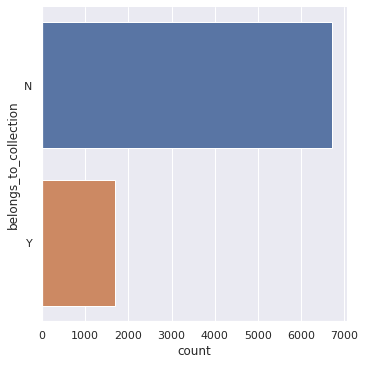

In [ ]:
sequelData= pd.DataFrame(clean_data['belongs_to_collection'])
sb.catplot(y = "belongs_to_collection", data = sequelData, kind = "count")

#### Distributions of all Numeric Variables
Drop all the catergory columns

In [ ]:
dropList = genres_cols.copy()
dropList.append('belongs_to_collection')
dropList.append('original_language')
numericData = pd.DataFrame(clean_data.drop(dropList, axis=1))
numericData.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,4000000,17.220,4257354,98.0,5.7,1902
1,21000000,9.568,12136938,110.0,6.5,184
2,11000000,74.841,775398007,121.0,8.2,15262
3,94000000,69.454,940335536,100.0,7.8,14760
4,55000000,49.459,677387716,142.0,8.5,20153


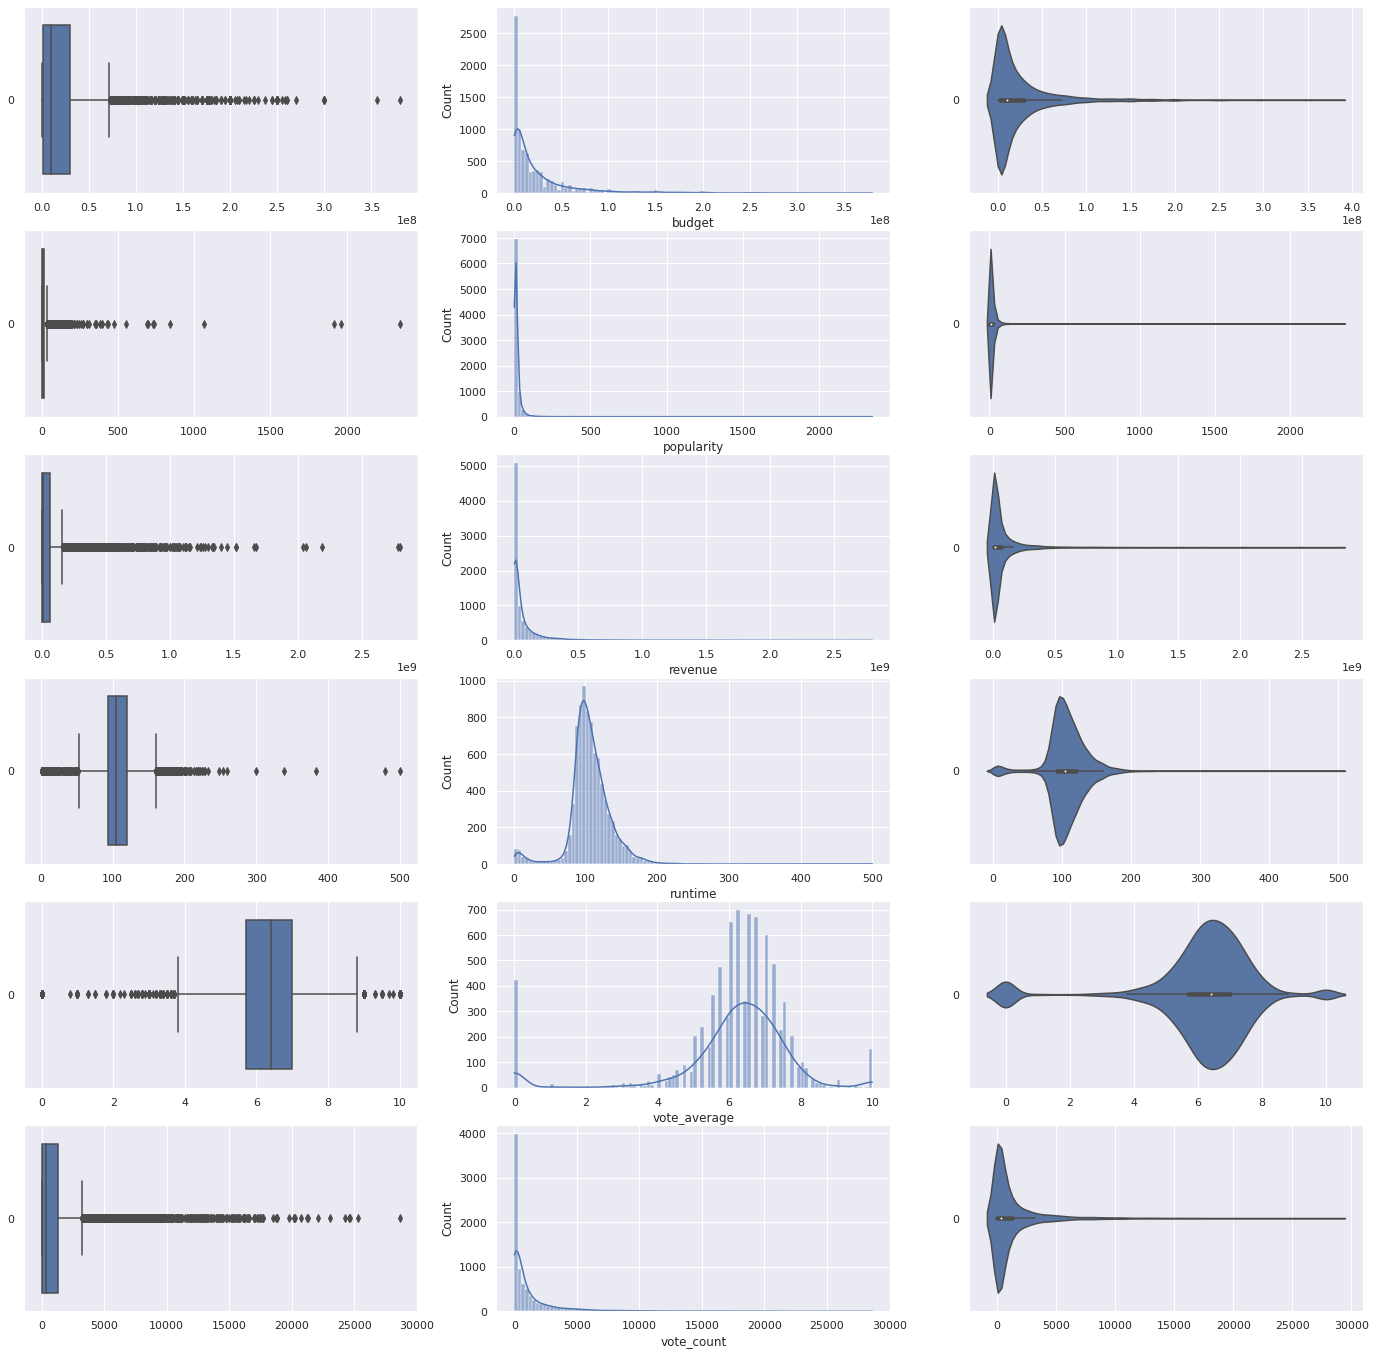

In [ ]:
f, axes = plt.subplots(6, 3, figsize=(24, 24))
count = 0
for var in numericData:
    sb.boxplot(data = numericData[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numericData[var], kde = True, ax = axes[count,1], bins = 100)
    sb.violinplot(data = numericData[var], orient = "h", ax = axes[count,2])
    count += 1

Due to the presence of many outliers, which causes the plot to skew a lot to the left, we will be removing these outliers to improve the visualization of our data.

In [ ]:
Q1 = numericData.quantile(0.25)
Q3 = numericData.quantile(0.75)
IQR = Q3 - Q1

visualData = numericData[~((numericData < (Q1 - 1.5 * IQR)) |(numericData > (Q3 + 1.5 * IQR))).any(axis=1)]
visualData.info()
visualData.index = np.arange(0, len(visualData))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5736 entries, 0 to 8366
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        5736 non-null   int64  
 1   popularity    5736 non-null   float64
 2   revenue       5736 non-null   int64  
 3   runtime       5736 non-null   float64
 4   vote_average  5736 non-null   float64
 5   vote_count    5736 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 313.7 KB


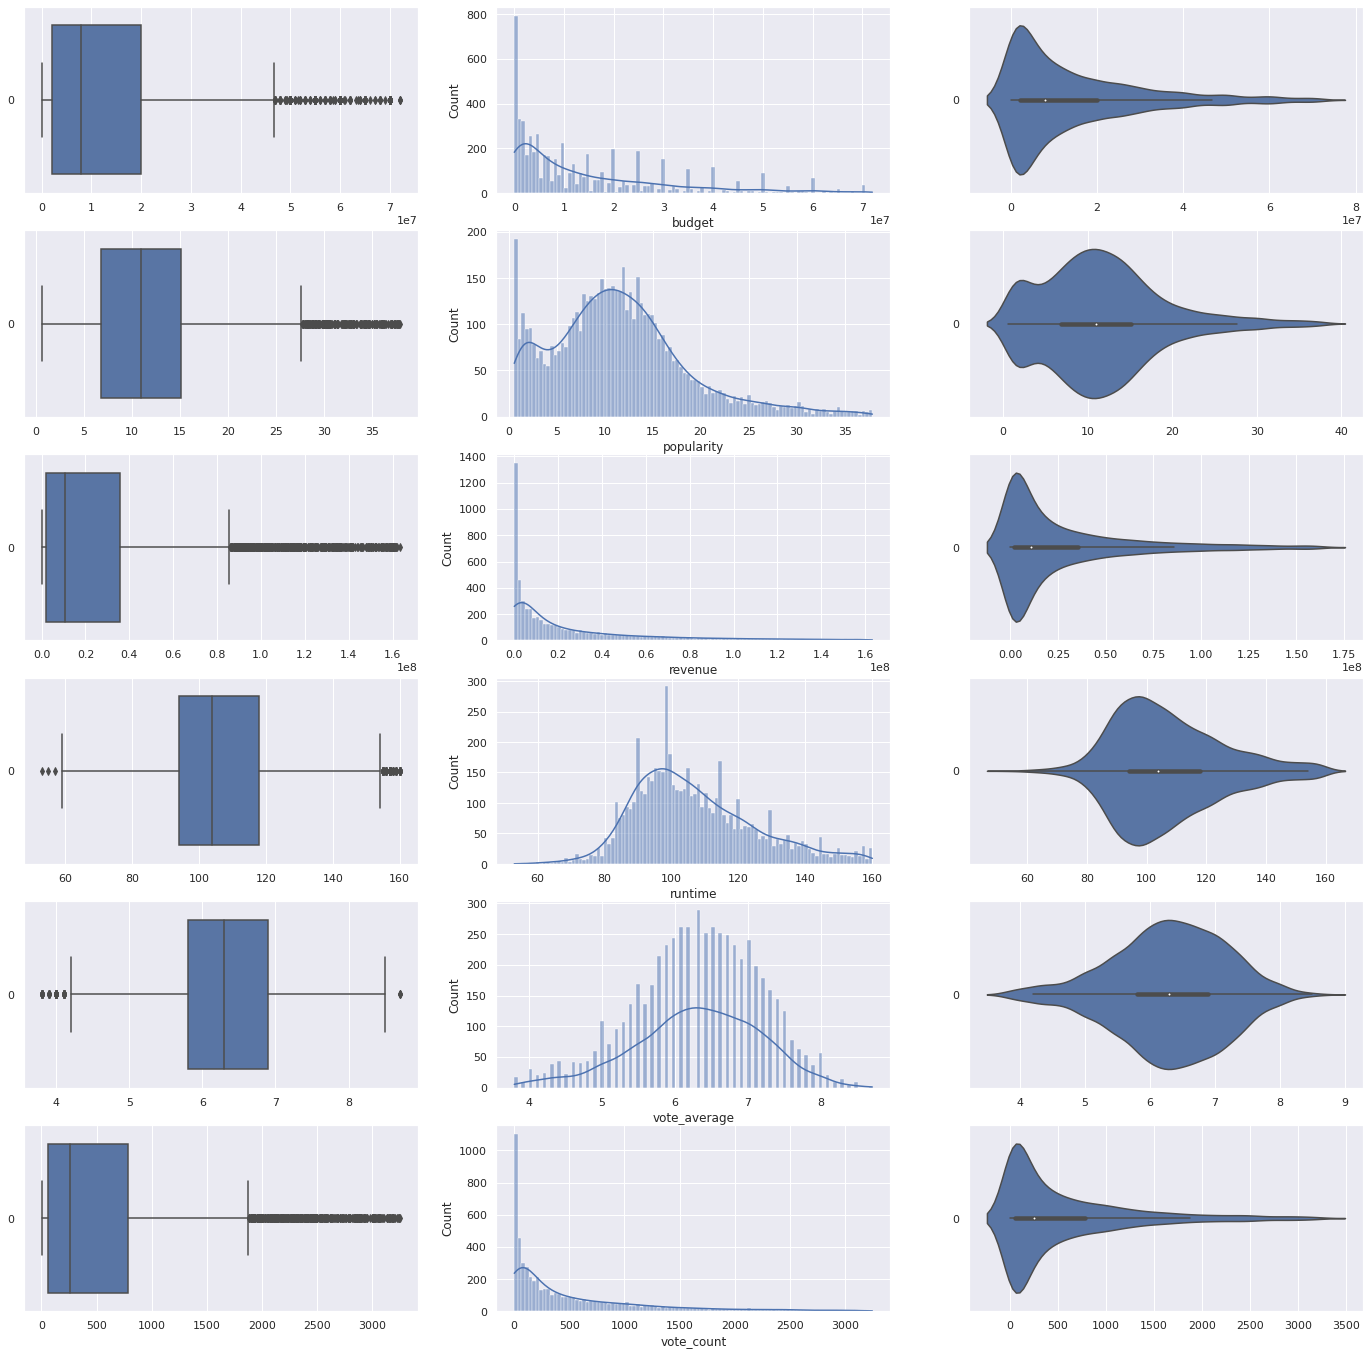

In [ ]:
f, axes = plt.subplots(6, 3, figsize=(24, 24))
count = 0
for var in visualData:
    sb.boxplot(data = visualData[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = visualData[var], kde = True, ax = axes[count,1], bins = 100)
    sb.violinplot(data = visualData[var], orient = "h", ax = axes[count,2])
    count += 1

Conclusion: Taking out extreme outliers improves the visualization of the plots.

#### belongs_to_collection variable determines whether the movie has a sequel.
As such, we will be plotting budget, popularity, revenue, runtime, vote_average and vote count against belongs_to_collection.

Plotting sequelData(belongs_to_collection) against budget

<AxesSubplot:xlabel='budget', ylabel='belongs_to_collection'>

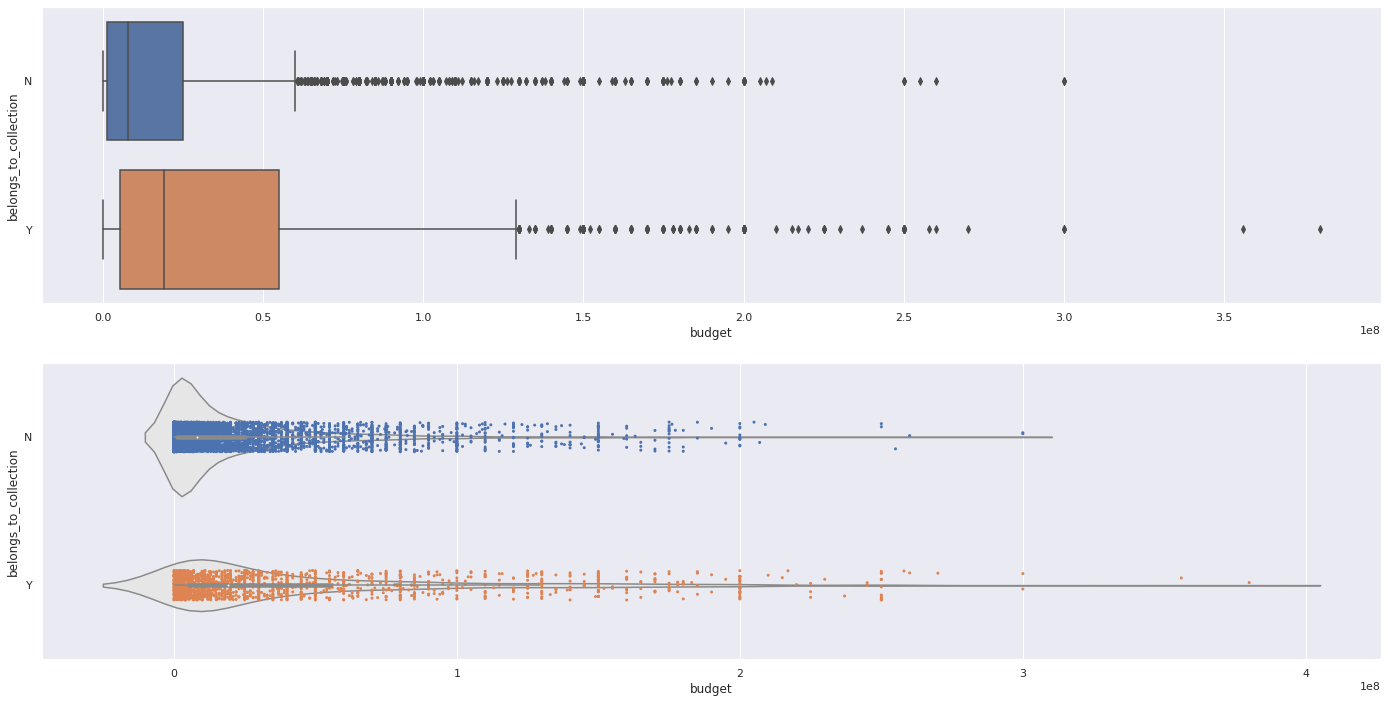

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and budget
swarmDF = pd.concat([sequelData, numericData.budget], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against budget
sb.boxplot(y="belongs_to_collection", x="budget", data=swarmDF , ax=axes[0])

# Joint Stripplot of belongs_to_collection against budget
sb.violinplot(y="belongs_to_collection", x="budget", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="budget", data=swarmDF, zorder=1, s=3, ax=axes[1])

Plotting sequelData(belongs_to_collection) against popularity

<AxesSubplot:xlabel='popularity', ylabel='belongs_to_collection'>

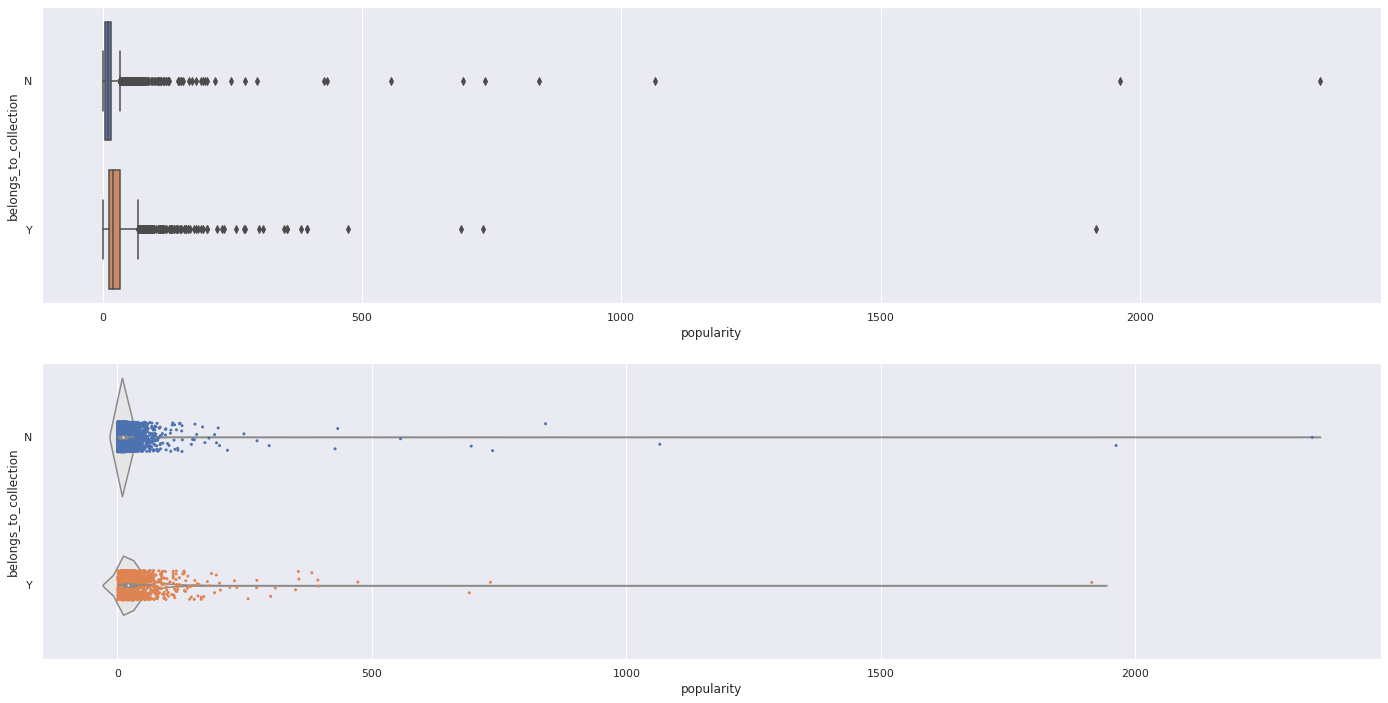

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and populartiy
swarmDF = pd.concat([sequelData, numericData.popularity], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against popularity
sb.boxplot(y="belongs_to_collection", x="popularity", data=swarmDF , ax=axes[0])

# Joint Stripplot of belongs_to_collection against popularity
sb.violinplot(y="belongs_to_collection", x="popularity", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="popularity", data=swarmDF, zorder=1, s=3, ax=axes[1])

Plotting sequelData(belongs_to_collection) against revenue

<AxesSubplot:xlabel='revenue', ylabel='belongs_to_collection'>

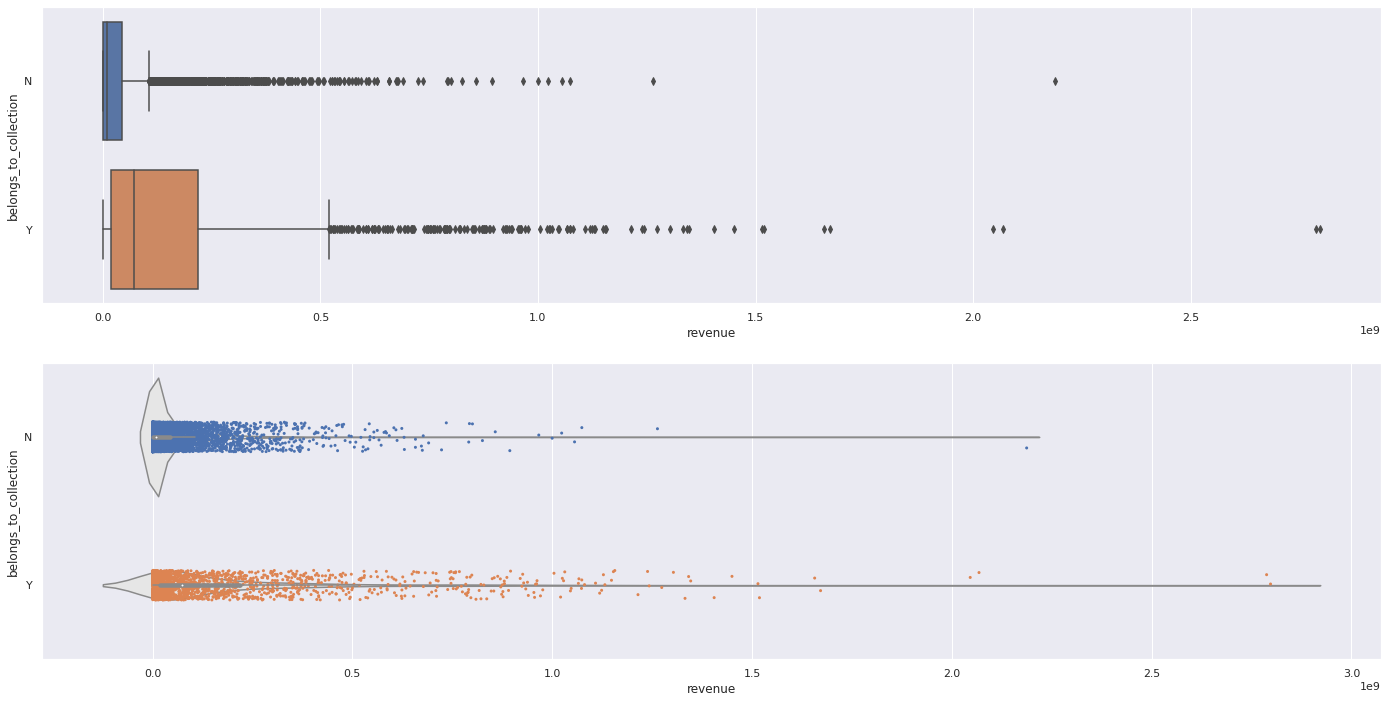

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and revenue
swarmDF = pd.concat([sequelData, numericData.revenue], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against revenue
sb.boxplot(y="belongs_to_collection", x="revenue", data=swarmDF , ax=axes[0])

# Joint Stripplot of belongs_to_collection against revenue
sb.violinplot(y="belongs_to_collection", x="revenue", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="revenue", data=swarmDF, zorder=1, s=3, ax=axes[1])

Plotting sequelData(belongs_to_collection) against runtime

<AxesSubplot:xlabel='runtime', ylabel='belongs_to_collection'>

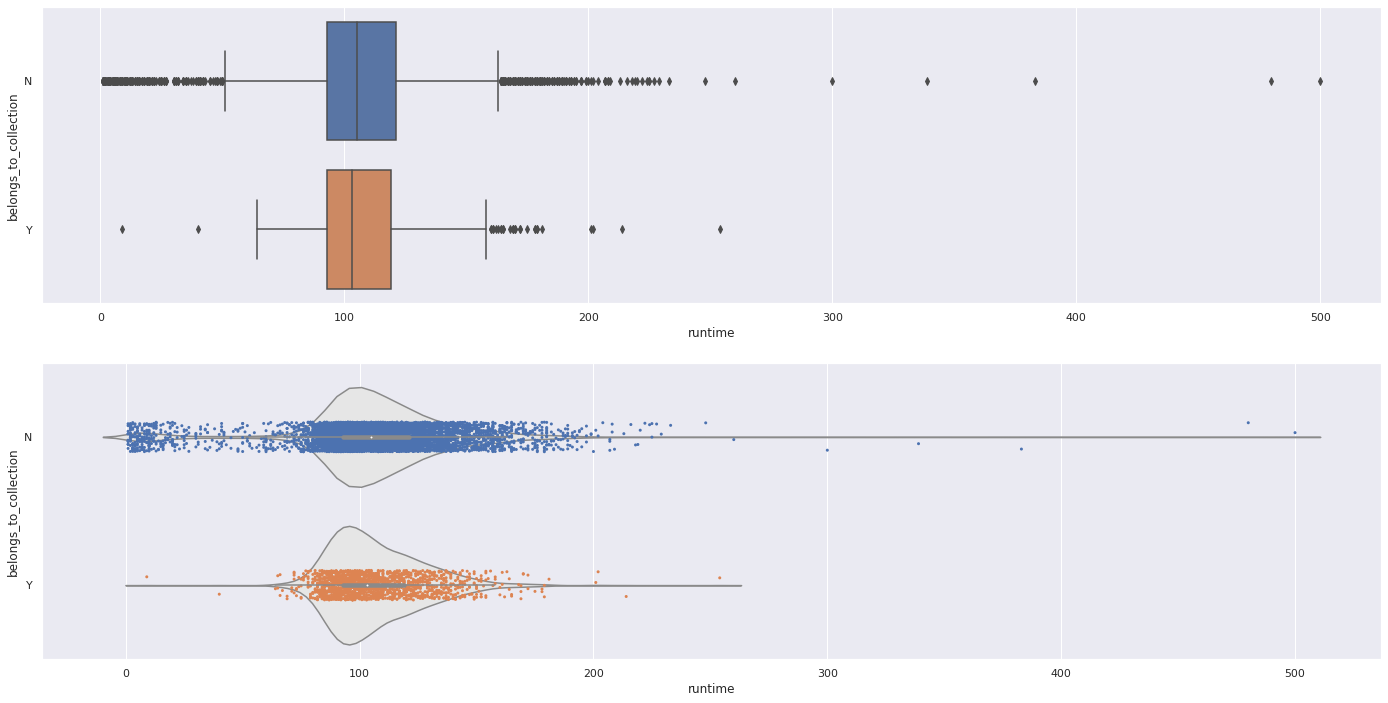

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and runtime
swarmDF = pd.concat([sequelData, numericData.runtime], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against runtime
sb.boxplot(y="belongs_to_collection", x="runtime", data=swarmDF , ax=axes[0])

# Joint Stripplot of belongs_to_collection against runtime
sb.violinplot(y="belongs_to_collection", x="runtime", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="runtime", data=swarmDF, zorder=1, s=3, ax=axes[1])

Plotting sequelData(belongs_to_collection) against vote_average

<AxesSubplot:xlabel='vote_average', ylabel='belongs_to_collection'>

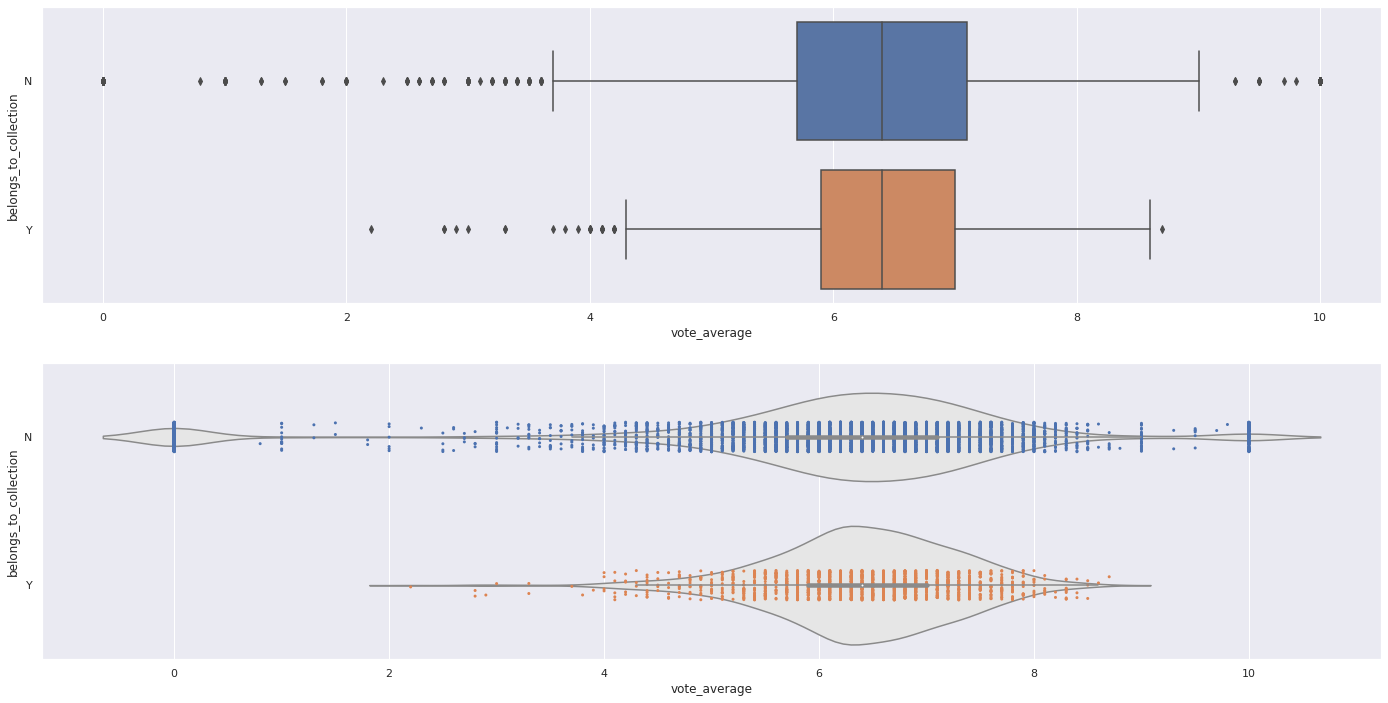

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and vote_average
swarmDF = pd.concat([sequelData, numericData.vote_average], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against vote_average
sb.boxplot(y="belongs_to_collection", x="vote_average", data=swarmDF , ax=axes[0])

# Joint Stripplot of belongs_to_collection against vote_average
sb.violinplot(y="belongs_to_collection", x="vote_average", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="vote_average", data=swarmDF, zorder=1, s=3, ax=axes[1])

Plotting sequelData(belongs_to_collection) against vote_count

<AxesSubplot:xlabel='vote_count', ylabel='belongs_to_collection'>

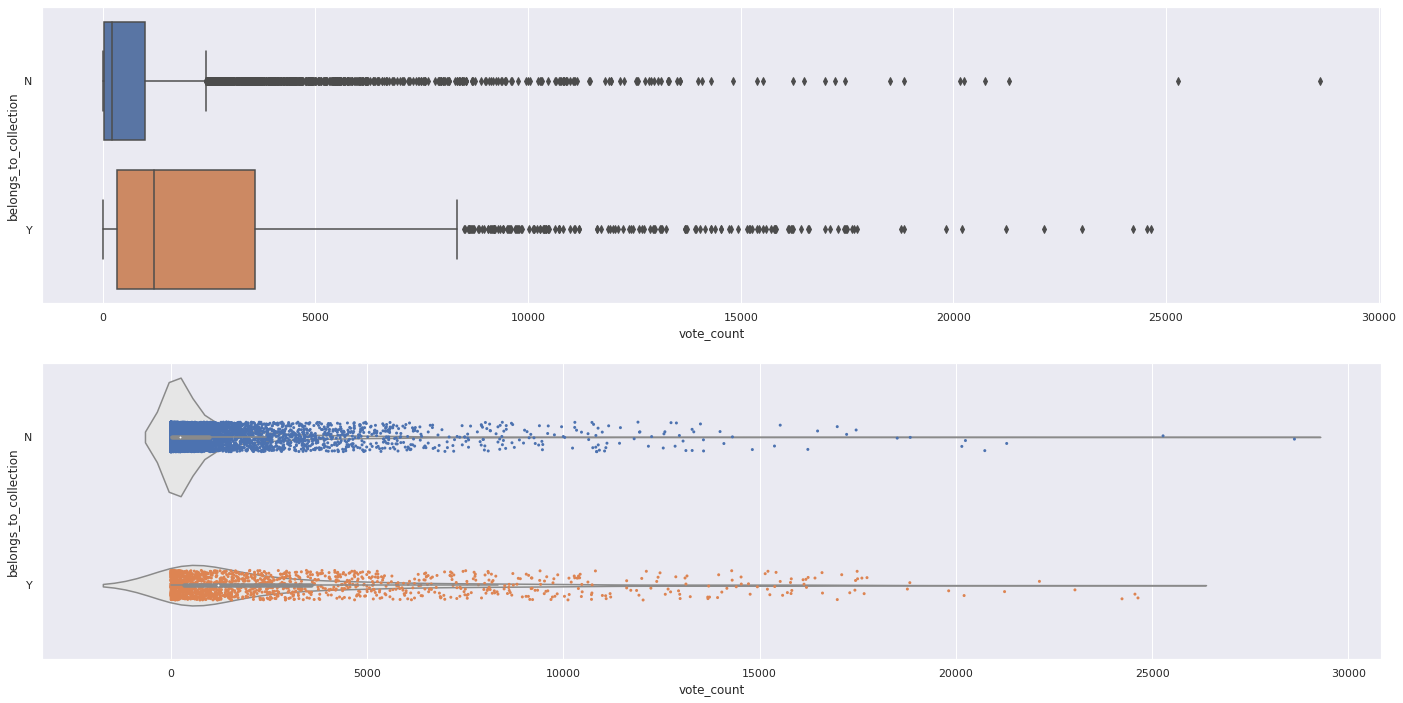

In [ ]:
# Create a joint dataframe by concatenating belonging_to_collection and vote_count
swarmDF = pd.concat([sequelData, numericData.vote_count], axis = 1).reindex(sequelData.index)



f, axes = plt.subplots(2, 1, figsize=(24, 12))
# Boxplot to identify important numeric information for belongs_to_collection against vote_count
sb.boxplot(y="belongs_to_collection", x="vote_count", data=swarmDF , ax=axes[0])

# Joint Striplot of belongs_to_collection against vote_count
sb.violinplot(y="belongs_to_collection", x="vote_count", data=swarmDF, color="0.9", ax=axes[1])
sb.stripplot(y="belongs_to_collection", x="vote_count", data=swarmDF, zorder=1, s=3, ax=axes[1])

#### Language and Genres categorical variables
Language


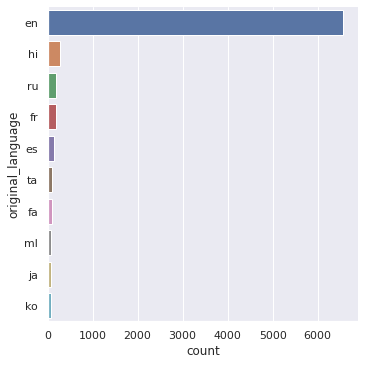

In [ ]:
# Showing the top 10 languages used in movies
top_10_lang = clean_data.original_language.value_counts().iloc[:10].index
sb.catplot(y = 'original_language', data = clean_data, kind = "count"
           , order=top_10_lang)

**Conclusion:** The English language primarily dominate the original_language column, followed by Hindi and Russian.

In [ ]:
# Calculating the percentage taken up by the top 10 languages used in movies.
count = 0
total = 0
for i in range(10):
    count += clean_data.original_language.value_counts().iloc[i]
for v in range(clean_data.original_language.unique().size):
    total += clean_data.original_language.value_counts().iloc[v]
print("Top 10 languages account for : " + "{:.2%}".format(count/total) + " of the movies")

Top 10 languages account for : 92.66% of the movies


In [ ]:
# Since the top 10 languages account for 92.66% of the movies in the dataset,
# we will be combining the remaining 52 languages into the variable "others"

for i in clean_data.original_language.value_counts().iloc[10:].index:
    clean_data.loc[clean_data.original_language == i, 'original_language'] = 'others'

clean_data.original_language.value_counts()

en        6574
others     617
hi         286
ru         183
fr         180
es         138
ta          96
fa          95
ml          85
ja          78
ko          69
Name: original_language, dtype: int64

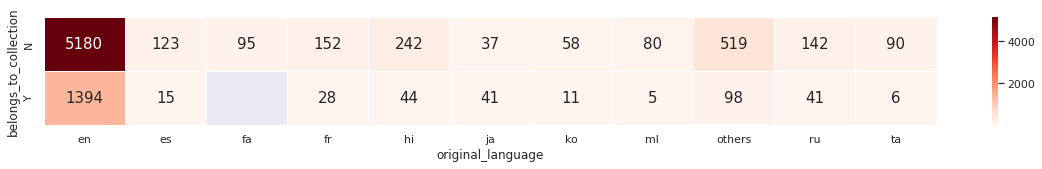

In [ ]:
# Distribution of the Two Types
f = plt.figure(figsize=(20, 2))
ax = sb.heatmap(clean_data.groupby(['belongs_to_collection', 'original_language']).size().unstack(), 
                linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "Reds", fmt='g')

In [ ]:
# Japanese seems to have the highest probability of sequels for the top 10 languages used with respect to their total number 
# of movies. As such, we will be calculating the percentage of sequels with respect to the number of movies for Japanese.
print("Percentage of sequels for Japanese Movies: " + "{:.2%}".format(41/(41+37)))

Percentage of sequels for Japanese Movies: 52.56%


**Conclusion:** Majority of the movies that have a sequel are in the English language. However, Japanese seems to have the highest percentage of sequels with 52.56% sequels among the top 10 languages used in movies.

Genres

In [ ]:
# Calculating the number of movies that is in each genre
genre_list = (clean_data[genres_cols] # Getting the genre columns
              .sum() # Summing up the values for each genre
              .sort_values(ascending=False) # Sort by descending order
               )
genre_list

Drama             4077.0
Comedy            2894.0
Action            2110.0
Thriller          2011.0
Romance           1514.0
Adventure         1317.0
Crime             1229.0
Horror             926.0
Family             842.0
Fantasy            754.0
Mystery            650.0
Animation          441.0
History            404.0
War                306.0
Music              295.0
Documentary        199.0
Western            125.0
ScienceFiction       0.0
TVMovie              0.0
dtype: float64

In [ ]:
# Since the genres: ScienceFiction and TVMovie have 0 movies in the dataset,
# we will be removing these genres to help aid in our data visualization

genre_list = (clean_data[genres_cols] # Get the genre columns only
              .sum() # Sum them up
              .sort_values(ascending=False) # Sort by descending order
              .index.values # Get the genre names
              )
genreDF = pd.DataFrame(clean_data[genre_list])
genreDF = genreDF.loc[:, (genreDF != 0).any(axis=0)]
clean_data = clean_data.drop(['ScienceFiction', 'TVMovie'], axis=1)
genreDF = genreDF.join(sequelData)

KeyError: "['ScienceFiction', 'TVMovie'] not in index"

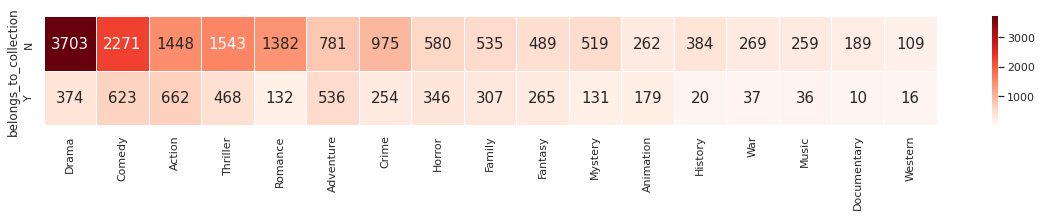

In [ ]:
f = plt.figure(figsize=(20, 2))
ax = sb.heatmap(genreDF.groupby("belongs_to_collection").sum(), 
                linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "Reds", fmt='g')    

In [ ]:
# Finding the genre with the highest percentage of sequels
df1 = genreDF.groupby("belongs_to_collection").sum()
highest = 0

for i in df1:
    if df1[i][1]/df1[i].sum() > highest:
        highest = df1[i][1]/df1[i].sum()
        genre = i

print("Genre of the movie with the highest percentage: " + genre)
print("Probability of a sequel: {:.2%}".format(highest))

Genre of the movie with the highest percentage: Adventure
Probability of a sequel: 40.70%


**Conclusion:** Majority of the movies that have a sequel are in the Action genre. However, Adventure genre have the highest percentage of sequels, with 40.70% sequels, among the movie genres.

## <div align = 'center'><b> Machine Learning </b></div>


#### Split into train and test sets

In [ ]:
clean_data.belongs_to_collection[clean_data.belongs_to_collection == 'Y'] = 1
clean_data.belongs_to_collection[clean_data.belongs_to_collection == 'N'] = 0

<ipython-input-175-cfd5c4c58bac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.belongs_to_collection[clean_data.belongs_to_collection == 'Y'] = 1
<ipython-input-175-cfd5c4c58bac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.belongs_to_collection[clean_data.belongs_to_collection == 'N'] = 0


In [ ]:
# Converting the categorical variable 'original_language' numeric binary variables
X = pd.get_dummies(clean_data.drop(['belongs_to_collection'], axis = 1))
y = pd.DataFrame(clean_data['belongs_to_collection'].astype(int))#.astype('category'))
# Using 30% of the dataset as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 9)


##### Machine Learning Algorithms

We will compare 2 different machine learning algorithms and determine which algorithm is the best for our data. We will use 10 fold cross validation to compare the performance between each model.

<h1 align = 'center'> Random Forest (Learning Something New) </h1>

**Random Forest**

A Random Forest is an ensemble learning method capable of performing tasks such as regression and classification through the construction of a multitude of decision trees and the use of a technique called Bootstrap Aggregation.

We will be using it here for classification.

Tuning the hyperparameters to obtain the best result for our prediction.

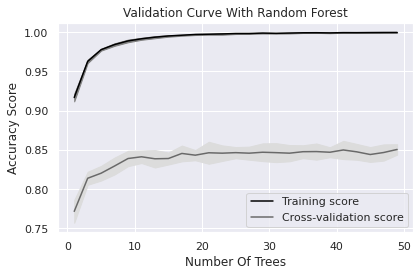

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, confusion_matrix

# Create range of values for parameter
param_range = np.arange(1, 50, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=10, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plotting the accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

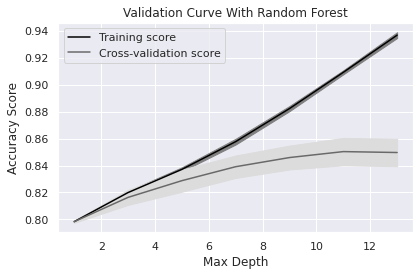

In [ ]:
# Create range of values for parameter
param_range = np.arange(1, 15, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=10, 
                                             # Uses a limited sample in order to estimate how the model is 
                                             # expected to perform in general when used to make predictions on data not 
                                             # used during the training of the model.
                                             # uses 1 test set and 9 training sets to determine accuracy
                                             # of machine learning model
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plotting the accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

<ipython-input-180-b9db3b27fa66>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)
Train Set:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      4694
           1       0.86      0.44      0.58      1186

    accuracy                           0.87      5880
   macro avg       0.87      0.71      0.75      5880
weighted avg       0.87      0.87      0.86      5880

Accuracy Score: 0.87228

Test Set:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      2024
           1       0.68      0.31      0.43       497

    accuracy                           0.84      2521
   macro avg       0.77      0.64      0.67      2521
weighted avg       0.82      0.84      0.81      2521

Accuracy Score: 0.83578


Text(0.5, 1.0, 'Test Set')

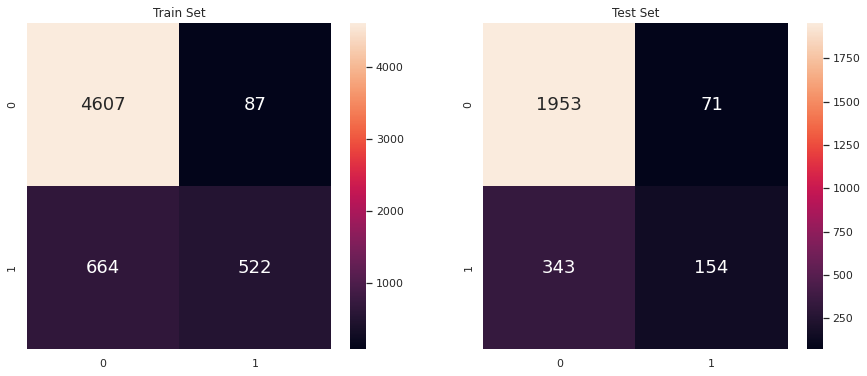

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
forest = RandomForestClassifier(n_estimators=20,
                               max_depth=8,
                               criterion='gini', 
                               random_state = 3, 
                               n_jobs=-1)
forest.fit(X_train, y_train)



# Predicting the response corresponding to the predictors
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)



# Generating the classification_report for the Train and Test sets
print("Train Set:\n" , classification_report(y_train,y_train_pred))
print("Accuracy Score: {:.5f}".format(accuracy_score(y_train, y_train_pred)))
print()
print("Test Set:\n" , classification_report(y_test,y_test_pred))
print("Accuracy Score: {:.5f}".format(accuracy_score(y_test, y_test_pred)))



# Computing the confusion_matrix for the train set
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))
sb.heatmap(confusion_matrix(y_train,y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax1)
ax1.set_title('Train Set')

# Computing the confusion_matrix for the test set
sb.heatmap(confusion_matrix(y_test,y_test_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax2)
ax2.set_title('Test Set')

In [ ]:
importance = pd.DataFrame(forest.feature_importances_, columns = ['weight'], index=X_train.columns)
importance.sort_values('weight', inplace=True)

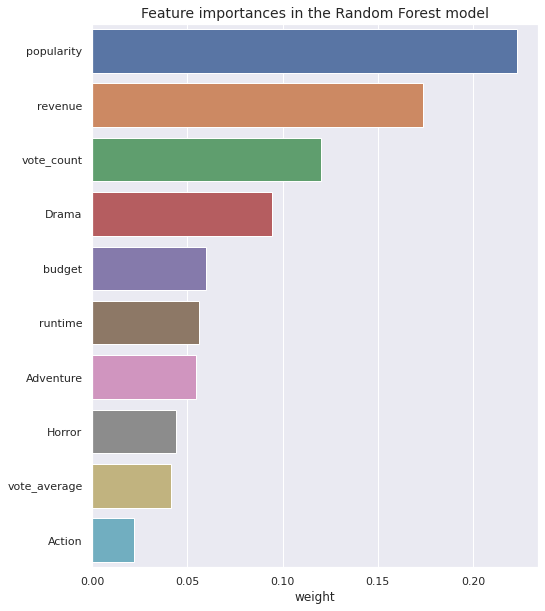

In [ ]:
top_10 = importance.sort_values(ascending=False, by=["weight"]).head(10)

# Plotting Feature Importances
plt.figure(figsize=(8,10))
sb.barplot(y = top_10.index, x = top_10.weight)
plt.title("Feature importances in the Random Forest model", fontsize=14)
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593:

<AxesSubplot:>

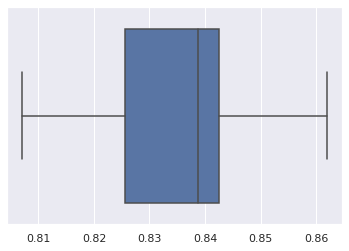

In [ ]:
kf_cv_scores = cross_val_score(forest, X, y, cv=10 )
print("\n10-fold CV average score: %.3f (std : %2f )"  % (kf_cv_scores.mean(),kf_cv_scores.std()))
sb.boxplot(kf_cv_scores)

Based on the weight of random forest model

**The top 10 most important features are:** 

1. Popularity <br>
2. Revenue
3. Vote Count
4. Drama
5. Budget
6. Runtime
7. Adventure
8. Horror
9. Vote Average
10. Action

**Conclusion**: Based on the experiment, an increase in depth or number of trees will lead to overfitting. Hence by using cross validation, we can best tune the hyperparameters for our random forest classification.

<h1 align = 'center'> XGBoost (Learning Something New) </h1>

XGBoost has a large range of hyperparameters. It combines the advantages from Random Forest and Gradient Boosting, significantly lowering prediction errors as compared to the 2 machine learning algorithms. Thus, we will be using XGBoost Classifier here to see if it improves our classification accuracy from Random Forest.

In [ ]:
from xgboost import plot_importance
from xgboost import DMatrix
import xgboost as xgb

dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

Baseline Mean Absolute Error

In [ ]:
from sklearn.metrics import mean_absolute_error

# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get baseline predictions on the test set
baseline_predictions = np.ones(y_test.shape) * float(mean_train)

# Compute Mean Absolute Error (MAE)
mae_baseline = mean_absolute_error(y_test, baseline_predictions)

print('Mean number of', mean_train)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Mean number of belongs_to_collection    0.201701
dtype: float64
Baseline MAE is 0.32


In [ ]:
# Default Hyperparameters
params = {
    # Hyperparameters that we are going to tune.
    'max_depth':8,
    'min_child_weight': 1,
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Leftover default parameter that we will not be tuning.
    'objective':'reg:squarederror',
}

In [ ]:
# Setting metric to mae and boost round to 999
params['eval_metric'] = "mae"
num_boost_round = 999

In [ ]:
# Default settings with early stopping round = 10
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best MAE: {:.5f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mae:0.41914
[1]	Test-mae:0.36153
[2]	Test-mae:0.32093
[3]	Test-mae:0.29021
[4]	Test-mae:0.27069
[5]	Test-mae:0.25595
[6]	Test-mae:0.24546
[7]	Test-mae:0.23909
[8]	Test-mae:0.23430
[9]	Test-mae:0.23134
[10]	Test-mae:0.22891
[11]	Test-mae:0.22788
[12]	Test-mae:0.22677
[13]	Test-mae:0.22592
[14]	Test-mae:0.22578
[15]	Test-mae:0.22538
[16]	Test-mae:0.22548
[17]	Test-mae:0.22571
[18]	Test-mae:0.22571
[19]	Test-mae:0.22645
[20]	Test-mae:0.22651
[21]	Test-mae:0.22690
[22]	Test-mae:0.22681
[23]	Test-mae:0.22744
[24]	Test-mae:0.22760
[25]	Test-mae:0.22787
Best MAE: 0.22538 with 16 rounds


Hypertuning: Using Cross Validation(CV) function to run cross validation across the Train Dataset to find the best MAE Score

In [ ]:
cross_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 23,
    nfold = 10,
    metrics={'mae'},
    early_stopping_rounds = 10
)

cross_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.403798,0.001280,0.418365,0.002646
1,0.332402,0.001310,0.359099,0.004641
2,0.279769,0.002097,0.317206,0.005759
3,0.240202,0.002027,0.287820,0.007126
4,0.210484,0.002572,0.266586,0.007615
5,0.188481,0.002535,0.251549,0.007579
6,0.172483,0.002742,0.240663,0.007931
7,0.160587,0.002972,0.233937,0.008142
8,0.151463,0.003267,0.229183,0.008600
9,0.143401,0.002719,0.225784,0.008804


In [ ]:
cross_results['test-mae-mean'].min()

0.22089429999999996

Hypertuning: Finding the optimum max_depth and min_child_weight

In [ ]:
# Setting the range of max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,8)
    for min_child_weight in range(1,5)
]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Updating our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=23,
        nfold=10,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Updating best MAE Score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=3, min_child_weight=1
	MAE 0.22533129999999998 for 63 rounds
CV with max_depth=3, min_child_weight=2
	MAE 0.22600729999999997 for 65 rounds
CV with max_depth=3, min_child_weight=3
	MAE 0.22603239999999997 for 75 rounds
CV with max_depth=3, min_child_weight=4
	MAE 0.2266771 for 45 rounds
CV with max_depth=4, min_child_weight=1
	MAE 0.2232342 for 42 rounds
CV with max_depth=4, min_child_weight=2
	MAE 0.22425829999999997 for 42 rounds
CV with max_depth=4, min_child_weight=3
	MAE 0.2244019 for 28 rounds
CV with max_depth=4, min_child_weight=4
	MAE 0.22325880000000004 for 48 rounds
CV with max_depth=5, min_child_weight=1
	MAE 0.22154589999999996 for 28 rounds
CV with max_depth=5, min_child_weight=2
	MAE 0.2219448 for 26 rounds
CV with max_depth=5, min_child_weight=3
	MAE 0.2199604 for 26 rounds
CV with max_depth=5, min_child_weight=4
	MAE 0.2212119 for 32 rounds
CV with max_depth=6, min_child_weight=1
	MAE 0.22032859999999999 for 23 rounds
CV with max_depth=6, min_child_we

In [ ]:
# Best max_depth and min_child_weight params
params['max_depth'] = 7
params['min_child_weight'] = 4

Hypertuning: Finding subsample and colsample_bytree

In [ ]:
# Setting the range of subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None

# Decrementing from the largest value to the smallest value
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Updating our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=23,
        nfold=10,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Updating best MAE Score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.21826979999999999 for 19 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.22209669999999998 for 16 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.2246147 for 16 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.22240279999999996 for 21 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.21958590000000006 for 17 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.2192644 for 17 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.2199112 for 17 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.22454739999999998 for 16 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.22138810000000003 for 16 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.22487970000000002 for 16 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.22428710000000004 for 14 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.2242263 for 17 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.2229088 for 15 rounds
CV with subsample=0.7, colsample=0.9
	MAE 0.2260339 for 15 rou

In [ ]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

Hypertuning: Finding learning rate (ETA)

In [ ]:
%time

# Finding the optimum ETA
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    
    # Updating our parameters
    params['eta'] = eta
    
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=23, nfold=10, metrics=['mae'], early_stopping_rounds=10)

    # Updating best MAE Score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
CV with eta=0.3
CPU times: user 14.5 s, sys: 436 ms, total: 14.9 s
Wall time: 30.5 s
	MAE 0.21826979999999999 for 19 rounds

CV with eta=0.2
CPU times: user 19.5 s, sys: 484 ms, total: 20 s
Wall time: 41.2 s
	MAE 0.2166045 for 28 rounds

CV with eta=0.1
CPU times: user 37.2 s, sys: 865 ms, total: 38.1 s
Wall time: 1min 17s
	MAE 0.21739429999999998 for 65 rounds

CV with eta=0.05
CPU times: user 1min 17s, sys: 1.88 s, total: 1min 19s
Wall time: 2min 39s
	MAE 0.2164288 for 146 rounds

CV with eta=0.01


CPU times: user 4min 20s, sys: 5.1 s, total: 4min 25s
Wall time: 7min 47s
	MAE 0.21596579999999999 for 676 rounds

CV with eta=0.005
CPU times: user 3min 20s, sys: 944 ms, total: 3min 21s
Wall time: 2min 14s
	MAE 0.21878760000000003 for 998 rounds

Best params: 0.01, MAE: 0.21596579999999999


In [ ]:
params['eta'] = 0.01

Results

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
    )
print("Best MAE: {:.5f} in {} rounds"
      .format(model.best_score, model.best_iteration+1))

[0]	Test-mae:0.49734
[1]	Test-mae:0.49471
[2]	Test-mae:0.49210
[3]	Test-mae:0.48952
[4]	Test-mae:0.48696
[5]	Test-mae:0.48444
[6]	Test-mae:0.48195
[7]	Test-mae:0.47948
[8]	Test-mae:0.47702
[9]	Test-mae:0.47461
[10]	Test-mae:0.47223
[11]	Test-mae:0.46987
[12]	Test-mae:0.46751
[13]	Test-mae:0.46521
[14]	Test-mae:0.46289
[15]	Test-mae:0.46062
[16]	Test-mae:0.45839
[17]	Test-mae:0.45616
[18]	Test-mae:0.45396
[19]	Test-mae:0.45179
[20]	Test-mae:0.44965
[21]	Test-mae:0.44751
[22]	Test-mae:0.44540
[23]	Test-mae:0.44329
[24]	Test-mae:0.44121
[25]	Test-mae:0.43912
[26]	Test-mae:0.43709
[27]	Test-mae:0.43506
[28]	Test-mae:0.43308
[29]	Test-mae:0.43108
[30]	Test-mae:0.42915
[31]	Test-mae:0.42721
[32]	Test-mae:0.42526
[33]	Test-mae:0.42341
[34]	Test-mae:0.42151
[35]	Test-mae:0.41961
[36]	Test-mae:0.41777
[37]	Test-mae:0.41590
[38]	Test-mae:0.41408
[39]	Test-mae:0.41224
[40]	Test-mae:0.41046
[41]	Test-mae:0.40870
[42]	Test-mae:0.40694
[43]	Test-mae:0.40517
[44]	Test-mae:0.40342
[45]	Test-mae:0.4016

[0]	Test-mae:0.49734
[1]	Test-mae:0.49471
[2]	Test-mae:0.49210
[3]	Test-mae:0.48952
[4]	Test-mae:0.48696
[5]	Test-mae:0.48444
[6]	Test-mae:0.48195
[7]	Test-mae:0.47948
[8]	Test-mae:0.47702
[9]	Test-mae:0.47461
[10]	Test-mae:0.47223
[11]	Test-mae:0.46987
[12]	Test-mae:0.46751
[13]	Test-mae:0.46521
[14]	Test-mae:0.46289
[15]	Test-mae:0.46062
[16]	Test-mae:0.45839
[17]	Test-mae:0.45616
[18]	Test-mae:0.45396
[19]	Test-mae:0.45179
[20]	Test-mae:0.44965
[21]	Test-mae:0.44751
[22]	Test-mae:0.44540
[23]	Test-mae:0.44329
[24]	Test-mae:0.44121
[25]	Test-mae:0.43912
[26]	Test-mae:0.43709
[27]	Test-mae:0.43506
[28]	Test-mae:0.43308
[29]	Test-mae:0.43108
[30]	Test-mae:0.42915
[31]	Test-mae:0.42721
[32]	Test-mae:0.42526
[33]	Test-mae:0.42341
[34]	Test-mae:0.42151
[35]	Test-mae:0.41961
[36]	Test-mae:0.41777
[37]	Test-mae:0.41590
[38]	Test-mae:0.41408
[39]	Test-mae:0.41224
[40]	Test-mae:0.41046
[41]	Test-mae:0.40870
[42]	Test-mae:0.40694
[43]	Test-mae:0.40517
[44]	Test-mae:0.40342
[45]	Test-mae:0.4016

Saving the model

In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:0.49734
[1]	Test-mae:0.49471
[2]	Test-mae:0.49210
[3]	Test-mae:0.48952
[4]	Test-mae:0.48696
[5]	Test-mae:0.48444
[6]	Test-mae:0.48195
[7]	Test-mae:0.47948
[8]	Test-mae:0.47702
[9]	Test-mae:0.47461
[10]	Test-mae:0.47223
[11]	Test-mae:0.46987
[12]	Test-mae:0.46751
[13]	Test-mae:0.46521
[14]	Test-mae:0.46289
[15]	Test-mae:0.46062
[16]	Test-mae:0.45839
[17]	Test-mae:0.45616
[18]	Test-mae:0.45396
[19]	Test-mae:0.45179
[20]	Test-mae:0.44965
[21]	Test-mae:0.44751
[22]	Test-mae:0.44540
[23]	Test-mae:0.44329
[24]	Test-mae:0.44121
[25]	Test-mae:0.43912
[26]	Test-mae:0.43709
[27]	Test-mae:0.43506
[28]	Test-mae:0.43308
[29]	Test-mae:0.43108
[30]	Test-mae:0.42915
[31]	Test-mae:0.42721
[32]	Test-mae:0.42526
[33]	Test-mae:0.42341
[34]	Test-mae:0.42151
[35]	Test-mae:0.41961
[36]	Test-mae:0.41777
[37]	Test-mae:0.41590
[38]	Test-mae:0.41408
[39]	Test-mae:0.41224
[40]	Test-mae:0.41046
[41]	Test-mae:0.40870
[42]	Test-mae:0.40694
[43]	Test-mae:0.40517
[44]	Test-mae:0.40342
[45]	Test-mae:0.4016

[0]	Test-mae:0.49734
[1]	Test-mae:0.49471
[2]	Test-mae:0.49210
[3]	Test-mae:0.48952
[4]	Test-mae:0.48696
[5]	Test-mae:0.48444
[6]	Test-mae:0.48195
[7]	Test-mae:0.47948
[8]	Test-mae:0.47702
[9]	Test-mae:0.47461
[10]	Test-mae:0.47223
[11]	Test-mae:0.46987
[12]	Test-mae:0.46751
[13]	Test-mae:0.46521
[14]	Test-mae:0.46289
[15]	Test-mae:0.46062
[16]	Test-mae:0.45839
[17]	Test-mae:0.45616
[18]	Test-mae:0.45396
[19]	Test-mae:0.45179
[20]	Test-mae:0.44965
[21]	Test-mae:0.44751
[22]	Test-mae:0.44540
[23]	Test-mae:0.44329
[24]	Test-mae:0.44121
[25]	Test-mae:0.43912
[26]	Test-mae:0.43709
[27]	Test-mae:0.43506
[28]	Test-mae:0.43308
[29]	Test-mae:0.43108
[30]	Test-mae:0.42915
[31]	Test-mae:0.42721
[32]	Test-mae:0.42526
[33]	Test-mae:0.42341
[34]	Test-mae:0.42151
[35]	Test-mae:0.41961
[36]	Test-mae:0.41777
[37]	Test-mae:0.41590
[38]	Test-mae:0.41408
[39]	Test-mae:0.41224
[40]	Test-mae:0.41046
[41]	Test-mae:0.40870
[42]	Test-mae:0.40694
[43]	Test-mae:0.40517
[44]	Test-mae:0.40342
[45]	Test-mae:0.4016

In [ ]:
# Parameters to be used for prediction of Train and Test set
params

{'max_depth': 7,
 'min_child_weight': 4,
 'eta': 0.01,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [ ]:
# Using XGB Classifier
clf = xgb.XGBClassifier(n_estimators = num_boost_round,
                        max_depth = 7,
                        learning_rate = 0.01,
                        subsample = 1.0,
                        colsample_bytree = 1.0,
                        random_state = 3,
                        objective = 'reg:squarederror',
                        n_jobs = -1,
                        use_label_encoder = False)

# Fitting the gradient boosting model to our dataset
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Train Set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      4694
           1       0.98      0.74      0.85      1186

    accuracy                           0.95      5880
   macro avg       0.96      0.87      0.91      5880
weighted avg       0.95      0.95      0.94      5880

Accuracy Score: 0.94592

Test Set:
               precision    recall  f1-score   support

           0       0.86      0.95      0.91      2024
           1       0.67      0.38      0.49       497

    accuracy                           0.84      2521
   macro avg       0.76      0.67      0.70      2521
weighted avg       0.82      0.84      0.82      2521

Accuracy Score: 0.84054


Text(0.5, 1.0, 'Test Set')

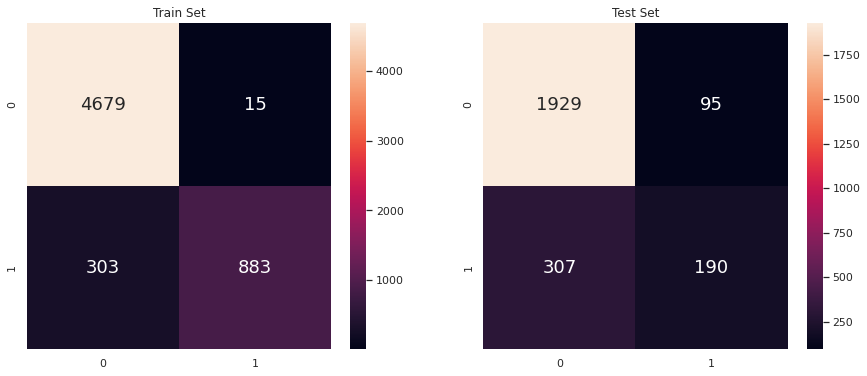

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Generating the classification_report for the Train and Test sets
print("Train Set:\n" , classification_report(y_train,y_train_pred))
print("Accuracy Score: {:.5f}".format(accuracy_score(y_train, y_train_pred)))
print()
print("Test Set:\n" , classification_report(y_test,y_test_pred))
print("Accuracy Score: {:.5f}".format(accuracy_score(y_test, y_test_pred)))



# Computing the confusion_matrix for the train set
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))
sb.heatmap(confusion_matrix(y_train,y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax1)
ax1.set_title('Train Set')

# Computing the confusion_matrix for the test set
sb.heatmap(confusion_matrix(y_test,y_test_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax2)
ax2.set_title('Test Set')

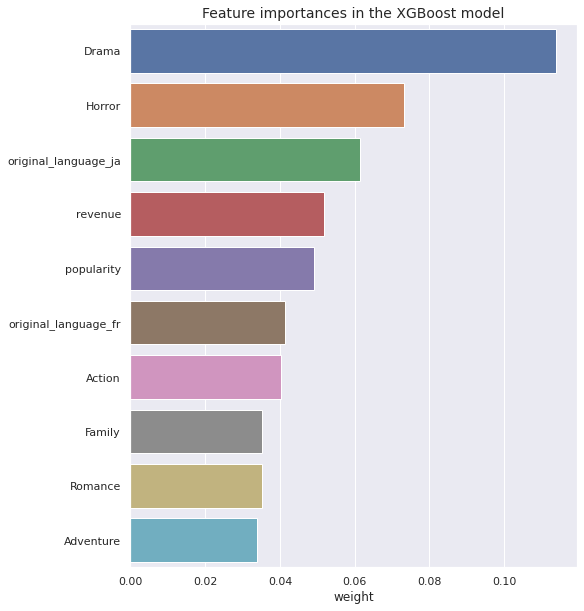

In [ ]:
importance = pd.DataFrame(clf.feature_importances_, columns = ['weight'], index=X_train.columns)
importance.sort_values('weight', inplace=True)

top_10 = importance.sort_values(ascending=False, by=["weight"]).head(10)
# Plot feature importance
plt.figure(figsize=(8,10))
sb.barplot(y = top_10.index, x = top_10.weight)
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.show()

/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/root/venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommend

<AxesSubplot:>

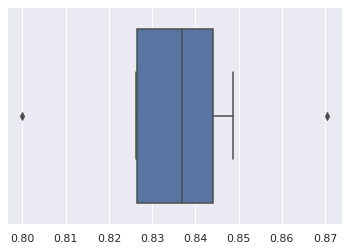

In [ ]:
kf_cv_scores = cross_val_score(clf, X, y, cv=10 )
print("\n10-fold CV average score: %.3f (std : %2f )"  % (kf_cv_scores.mean(),kf_cv_scores.std()))
sb.boxplot(kf_cv_scores)

Based on the weight of XGBoost model

**The top 10 most important features are:** 

1. Drama
2. Horror
3. Japanese Language
4. Revenue
5. Popularity
6. France Language
7. Action
8. Family
9. Romance
10. Adventure

**Conclusion**: From the experiment, XGBoost performed better than Random Forest in Test Accuracy and 10-fold cross validation score.

### Overall Conclusion

XGBoost is the better model of the 2 when predicting whether a movie is going to have a sequel or not.

As such, using the XGBoost model, the genre "Drama" is the best variable in predicting the outcome of a sequel.

### References
- https://developers.themoviedb.org/3/getting-started
- https://github.com/celiao/tmdbsimple
- https://scikit-learn.org/stable/user_guide.html
- https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e5e9092-6f69-48c4-92f4-c75f25ddf821' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>